In [2]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
import numpy as np
from itertools import combinations

In [3]:
class OneVsOneClassifierCustom(BaseEstimator, ClassifierMixin):
    def __init__(self, base_model=LogisticRegression):
        self.base_model = base_model
        self.models = []
        self.class_pairs = []

    def fit(self, X, y):
        self.models = []
        self.class_pairs = []

        # Obtener clases únicas
        classes = np.unique(y)
        
        # Crear combinaciones de pares (0 vs 1), (0 vs 2), ...
        for (c1, c2) in combinations(classes, 2):
            # Filtrar dataset por solo esas dos clases
            idx = np.where((y == c1) | (y == c2))
            X_pair = X[idx]
            y_pair = y[idx]

            # Modelo nuevo
            model = self.base_model()
            model.fit(X_pair, y_pair)

            self.models.append(model)
            self.class_pairs.append((c1, c2))
        
        return self

    def predict(self, X):
        votes = np.zeros((X.shape[0], len(self.class_pairs)))
        
        predictions = []
        for i, model in enumerate(self.models):
            preds = model.predict(X)
            votes[:, i] = preds
        
        # Voto mayoritario por fila
        final_preds = []
        for row in votes:
            counts = np.bincount(row.astype(int))
            final_preds.append(np.argmax(counts))
        
        return np.array(final_preds)

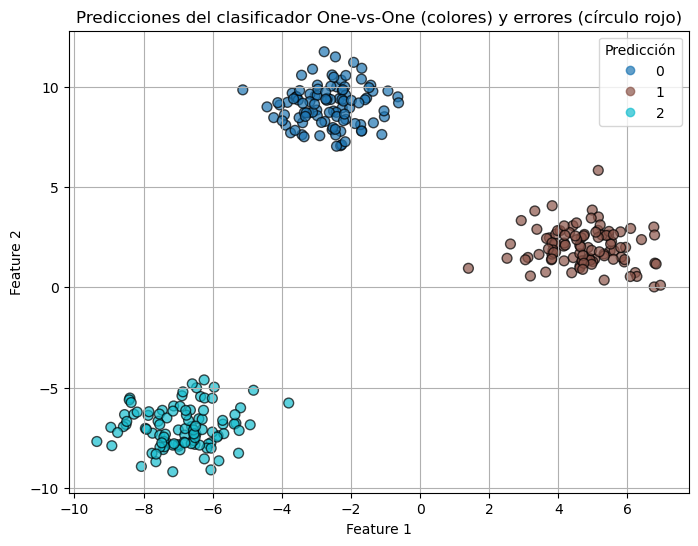

In [4]:
from sklearn.datasets import make_blobs

# Generar datos de ejemplo, entrenar el clasificador y mostrar una gráfica de predicciones
import matplotlib.pyplot as plt

# Datos de ejemplo
X, y = make_blobs(n_samples=300, centers=3, cluster_std=1.0, random_state=42)

# Entrenar el clasificador One-vs-One definido en la celda anterior
clf = OneVsOneClassifierCustom(base_model=LogisticRegression)
clf.fit(X, y)
y_pred = clf.predict(X)

# Graficar: colores = predicciones, marcar errores
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='tab10', s=50, alpha=0.7, edgecolor='k')
# Marcar puntos mal clasificados
mis = (y_pred != y)
if mis.any():
    plt.scatter(X[mis, 0], X[mis, 1], facecolors='none', edgecolors='red', s=100, linewidths=1.5, label='Misclassified')

plt.title('Predicciones del clasificador One-vs-One (colores) y errores (círculo rojo)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(*scatter.legend_elements(), title="Predicción", loc='upper right')
plt.grid(True)
plt.show()